In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 
import random 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('punkt')  # baixa os recursos necessários para a tokenização

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.float_format', '{:.2f}'.format)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# set global seed 
seed = 42
np.random.seed(seed)

In [4]:
# load XML
df_train = pd.read_xml("/content/drive/MyDrive/ICMC/Introducao-PLN/atividades/exercicio-03/assin2-train-only.xml")
df_test = pd.read_xml("/content/drive/MyDrive/ICMC/Introducao-PLN/atividades/exercicio-03/assin2-test.xml")

df_train.head()

,entailment,id,similarity,t,h
0,Entailment,1,4.50,Uma criança risonha está segurando uma pistola...,Uma criança está segurando uma pistola de água
1,Entailment,2,4.50,Os homens estão cuidadosamente colocando as ma...,Os homens estão colocando bagagens dentro do p...
2,Entailment,3,4.70,Uma pessoa tem cabelo loiro e esvoaçante e est...,Um guitarrista tem cabelo loiro e esvoaçante
3,Entailment,4,4.70,Batatas estão sendo fatiadas por um homem,O homem está fatiando a batata
4,Entailment,5,4.90,Um caminhão está descendo rapidamente um morro,Um caminhão está rapidamente descendo o morro


In [5]:
# estrategia de concaternar T e H 

df_train["t"] = df_train["t"].astype(str)
df_train["h"] = df_train["h"].astype(str)

df_test["t"] = df_test["t"].astype(str)
df_test["h"] = df_test["h"].astype(str)

df_train["text_concat"] = df_train["t"] +  " [SEP] " + df_train["h"]
df_test["text_concat"] = df_test["t"] +  " [SEP] " + df_test["h"]

In [6]:
# transformar label (entailment = 1 | none = 0)
df_train["label"] = df_train["entailment"].apply(lambda x: 1 if x=="Entailment" else 0)
df_test["label"] = df_test["entailment"].apply(lambda x: 1 if x=="Entailment" else 0)

In [7]:
df_train.head(2)

,entailment,id,similarity,t,h,text_concat,label
0,Entailment,1,4.50,Uma criança risonha está segurando uma pistola...,Uma criança está segurando uma pistola de água,Uma criança risonha está segurando uma pistola...,1
1,Entailment,2,4.50,Os homens estão cuidadosamente colocando as ma...,Os homens estão colocando bagagens dentro do p...,Os homens estão cuidadosamente colocando as ma...,1


<br>
<hr>
<br>
<br>

### 1. CatBoost + Concatenacao (t + h)

<br>

In [8]:
# split dados 
X_train, y_train = df_train[['t', 'h']], df_train["label"]
X_test, y_test  = df_test[['t', 'h']], df_test['label']

In [9]:
type(X_train), type(y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [10]:
# criar o objeto do classificador CatBoost
cat_model = CatBoostClassifier()

# separar as colunas de entrada (string) das colunas de entrada numéricas
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]

# treinar o modelo
cat_model.fit(X_train, y_train, cat_features=categorical_features_indices)

Learning rate set to 0.022911
0:	learn: 0.6874868	total: 56.1ms	remaining: 56s
1:	learn: 0.6827149	total: 61.8ms	remaining: 30.8s
2:	learn: 0.6779579	total: 67.8ms	remaining: 22.5s
3:	learn: 0.6736634	total: 73.5ms	remaining: 18.3s
4:	learn: 0.6690440	total: 79ms	remaining: 15.7s
5:	learn: 0.6647179	total: 84.7ms	remaining: 14s
6:	learn: 0.6606157	total: 91ms	remaining: 12.9s
7:	learn: 0.6565988	total: 97.5ms	remaining: 12.1s
8:	learn: 0.6530353	total: 104ms	remaining: 11.4s
9:	learn: 0.6499720	total: 109ms	remaining: 10.8s
10:	learn: 0.6465210	total: 115ms	remaining: 10.3s
11:	learn: 0.6437753	total: 120ms	remaining: 9.85s
12:	learn: 0.6407029	total: 126ms	remaining: 9.58s
13:	learn: 0.6377344	total: 133ms	remaining: 9.37s
14:	learn: 0.6349655	total: 138ms	remaining: 9.08s
15:	learn: 0.6324720	total: 144ms	remaining: 8.87s
16:	learn: 0.6306220	total: 151ms	remaining: 8.75s
17:	learn: 0.6285378	total: 157ms	remaining: 8.58s
18:	learn: 0.6268061	total: 165ms	remaining: 8.49s
19:	learn: 


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.11      0.18      1224
           1       0.50      0.88      0.64      1224

    accuracy                           0.50      2448
   macro avg       0.49      0.50      0.41      2448
weighted avg       0.49      0.50      0.41      2448


 Confusion Matrix:


<Axes: title={'center': 'Matriz confusão Catboost'}>

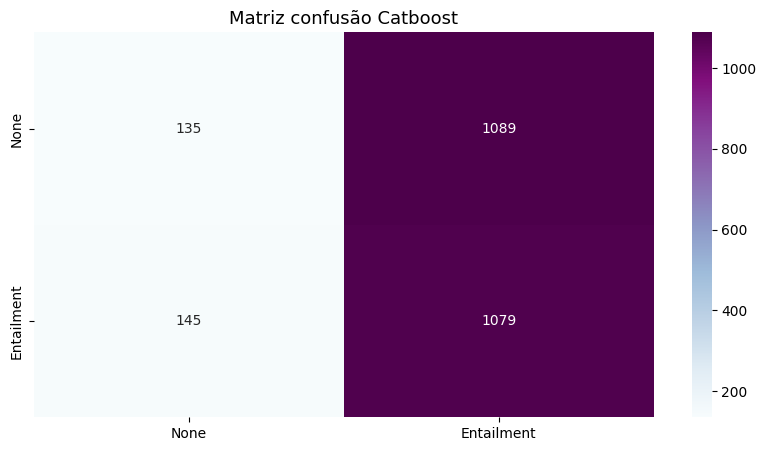

In [11]:
# Predição do conjunto de teste
y_pred = cat_model.predict(X_test)

# redondar 
y_pred = np.round(y_pred)

#  matriz de confusao 
cm = confusion_matrix(y_test, y_pred)
# Configura a opção de impressão para exibir todos os dígitos decimais
np.set_printoptions(precision=3, suppress=True)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("\n Confusion Matrix:")
classes = ["None", "Entailment"]
plt.figure(figsize=(10,5))
plt.title('Matriz confusão Catboost', fontsize=13)
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d', xticklabels=classes, yticklabels=classes)

In [12]:
inferencia = pd.DataFrame(columns=["t", "h"])

# exemplo de entailment 
inferencia.loc[0] = "Crianças estão sendo vestidas em fantasias e jogando um jogo" + " [SEP] " + "Crianças estão sendo vestidas com fantasias e jogando um jogo"
# exemplo de none 
inferencia.loc[1] = "Pessoas não estão jogando críquete" + " [SEP] " + "As pessoas estão jogando críquete"

In [13]:
inferencia.head()

,t,h
0,Crianças estão sendo vestidas em fantasias e j...,Crianças estão sendo vestidas em fantasias e j...
1,Pessoas não estão jogando críquete [SEP] As pe...,Pessoas não estão jogando críquete [SEP] As pe...


In [14]:
inferencia.iloc[0]["t"], inferencia.iloc[0]["h"]

('Crianças estão sendo vestidas em fantasias e jogando um jogo [SEP] Crianças estão sendo vestidas com fantasias e jogando um jogo',
 'Crianças estão sendo vestidas em fantasias e jogando um jogo [SEP] Crianças estão sendo vestidas com fantasias e jogando um jogo')

In [15]:
y_inferencia = cat_model.predict(inferencia)

In [16]:
y_inferencia = np.round(y_inferencia)

In [17]:
y_inferencia

array([1, 1])

<br>
<hr>
<br>
<br>


#### 2. Modelagem Embeddings (media) + CatBoost 

<br>

In [18]:
# download embeddings (Word2Vec Skip-gram 300 DIM)
!wget http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s50.zip
!unzip download.php?file=embeddings%2Fword2vec%2Fskip_s50.zip

--2023-05-01 14:40:46--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s50.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176485664 (168M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fword2vec%2Fskip_s50.zip.1’

download.php?file=e 100%[===================>] 168.31M  11.2MB/s    in 16s     

2023-05-01 14:41:02 (10.6 MB/s) - ‘download.php?file=embeddings%2Fword2vec%2Fskip_s50.zip.1’ saved [176485664/176485664]

Archive:  download.php?file=embeddings%2Fword2vec%2Fskip_s50.zip
replace skip_s50.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: skip_s50.txt            


In [19]:
# processar embeddings (embeddings em um dicionario)
embedding_path = "skip_s50.txt"

embeddings_index = {}
with open(embedding_path) as f:
    for line in f:
        values = line.split()
        word = value = values[0]
        coefs = []
        for val in values[1:]:
            try:
                coefs.append(float(val.replace(',', '.')))
            except ValueError:
                pass
        embeddings_index[word] = np.asarray(coefs, dtype='float32')

In [20]:
len(embeddings_index)

929595

In [21]:
# teste - buscando palavra na matrix de embeddings
print(embeddings_index["críquete"])

[-0.505  0.443 -0.029 -0.187  0.121  0.315 -0.117  0.017  0.497  0.006
 -0.199 -0.217  0.021 -0.075 -0.246 -0.469 -0.024 -0.319 -0.626 -0.066
  0.275  0.147 -0.735 -0.834 -0.009 -0.035  0.09   0.245  0.147  0.167
 -0.285  0.198 -0.272  0.126 -0.335  0.083 -0.113 -0.438  0.508 -0.607
  0.588  0.031  0.214 -0.624 -0.592 -0.213  0.371  0.427  0.098 -0.296]


In [22]:
# teste - buscando palavra na matrix de embeddings
print(embeddings_index["água"])

[-0.35  -0.183  0.38  -0.619 -0.337 -0.404 -0.291 -0.055  0.469 -0.998
  0.293  0.365 -0.223 -1.084 -0.556 -0.145 -0.243 -0.615  0.227  0.181
  0.679  0.83   0.707 -0.03  -0.169 -0.301 -0.641 -0.486 -0.758 -0.007
  1.295 -0.819  0.423  0.156  0.405  0.219  0.301  0.032 -0.967 -0.061
  0.229 -0.326  0.178 -0.376 -0.573  0.412  0.287  0.393  0.011  0.028]


<br>
<br>
<hr>
<br>
<br>

In [23]:
# copia de dataframes
df_embeddings_train = df_train.copy()
df_embeddings_test = df_test.copy()

In [24]:
# extrair a media dos embeddings 

def embeddings_func(frase):

   # aplicar lower case 
   frase = frase.lower()

   # tokenização 
   tokens = nltk.tokenize.word_tokenize(frase)

   # correspondencia de embeddings 
   sentenca = []
   for word in tokens: 
      if word in embeddings_index:
         sentenca.append(embeddings_index[word])
      else: 
         sentenca.append(np.zeros((50,))) # vetor de zeros se a palavra não tiver embedding

   sentenca = np.mean(sentenca) # media embeddings
   return sentenca  # transforma a lista de embeddings em uma matriz

In [25]:
# aplicando base treino
df_embeddings_train['embedding_t'] = df_embeddings_train['t'].apply(embeddings_func)
df_embeddings_train['embedding_h'] = df_embeddings_train['h'].apply(embeddings_func)

# aplicando base teste 
df_embeddings_test['embedding_t'] = df_embeddings_test['t'].apply(embeddings_func)
df_embeddings_test['embedding_h'] = df_embeddings_test['h'].apply(embeddings_func)

In [26]:
# validando transformacao (media embeddings)
df_embeddings_train.iloc[0]["embedding_t"], df_embeddings_train.iloc[0]["embedding_h"]

(-0.03387797623872757, -0.034808844327926636)

In [27]:
# validando transformacao (media embeddings)
df_embeddings_train.iloc[0]["embedding_t"], df_embeddings_train.iloc[5000]["embedding_h"]

(-0.03387797623872757, -0.030732884428231046)

In [28]:
df_embeddings_train.head(3)

,entailment,id,similarity,t,h,text_concat,label,embedding_t,embedding_h
0,Entailment,1,4.50,Uma criança risonha está segurando uma pistola...,Uma criança está segurando uma pistola de água,Uma criança risonha está segurando uma pistola...,1,-0.03,-0.03
1,Entailment,2,4.50,Os homens estão cuidadosamente colocando as ma...,Os homens estão colocando bagagens dentro do p...,Os homens estão cuidadosamente colocando as ma...,1,-0.01,-0.03
2,Entailment,3,4.70,Uma pessoa tem cabelo loiro e esvoaçante e est...,Um guitarrista tem cabelo loiro e esvoaçante,Uma pessoa tem cabelo loiro e esvoaçante e est...,1,-0.02,-0.03


In [29]:
# lower case texto 
df_embeddings_train["t"] = df_embeddings_train["t"].apply(lambda x: x.lower())
df_embeddings_train["h"] = df_embeddings_train["h"].apply(lambda x: x.lower())


df_embeddings_test["t"] = df_embeddings_test["t"].apply(lambda x: x.lower())
df_embeddings_test["h"] = df_embeddings_test["h"].apply(lambda x: x.lower())

In [30]:
# split dados 
X_train, y_train = df_embeddings_train[['t', 'h', 'embedding_t', 'embedding_h']], df_embeddings_train["label"]
X_test, y_test  = df_embeddings_test[['t', 'h', 'embedding_t', 'embedding_h']], df_embeddings_test['label']

In [31]:
X_train.head(3)

,t,h,embedding_t,embedding_h
0,uma criança risonha está segurando uma pistola...,uma criança está segurando uma pistola de água,-0.03,-0.03
1,os homens estão cuidadosamente colocando as ma...,os homens estão colocando bagagens dentro do p...,-0.01,-0.03
2,uma pessoa tem cabelo loiro e esvoaçante e est...,um guitarrista tem cabelo loiro e esvoaçante,-0.02,-0.03


In [32]:
# criar o objeto do classificador CatBoost
catboost_embedding_model = CatBoostClassifier()

# separar as colunas de entrada (string) das colunas de entrada numéricas
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]

# treinar o modelo
catboost_embedding_model.fit(X_train, y_train, cat_features=categorical_features_indices)

Learning rate set to 0.022911
0:	learn: 0.6878561	total: 10.5ms	remaining: 10.5s
1:	learn: 0.6832816	total: 16.7ms	remaining: 8.34s
2:	learn: 0.6786286	total: 24.8ms	remaining: 8.24s
3:	learn: 0.6742733	total: 32.4ms	remaining: 8.08s
4:	learn: 0.6702751	total: 39.7ms	remaining: 7.91s
5:	learn: 0.6660496	total: 51.9ms	remaining: 8.59s
6:	learn: 0.6624126	total: 67.3ms	remaining: 9.55s
7:	learn: 0.6585710	total: 75.5ms	remaining: 9.36s
8:	learn: 0.6554721	total: 83.1ms	remaining: 9.15s
9:	learn: 0.6517662	total: 90ms	remaining: 8.91s
10:	learn: 0.6483638	total: 96.5ms	remaining: 8.68s
11:	learn: 0.6451684	total: 103ms	remaining: 8.47s
12:	learn: 0.6419575	total: 109ms	remaining: 8.31s
13:	learn: 0.6391848	total: 117ms	remaining: 8.26s
14:	learn: 0.6369402	total: 124ms	remaining: 8.14s
15:	learn: 0.6339869	total: 131ms	remaining: 8.06s
16:	learn: 0.6311882	total: 138ms	remaining: 7.98s
17:	learn: 0.6287128	total: 145ms	remaining: 7.9s
18:	learn: 0.6262278	total: 152ms	remaining: 7.84s
19:

In [33]:
# Predição do conjunto de teste
y_pred = catboost_embedding_model.predict(X_test)

# redondar 
y_pred = np.round(y_pred)


Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.13      0.21      1224
           1       0.51      0.89      0.65      1224

    accuracy                           0.51      2448
   macro avg       0.52      0.51      0.43      2448
weighted avg       0.52      0.51      0.43      2448


 Confusion Matrix:


<Axes: title={'center': 'Matriz confusão Catboost'}>

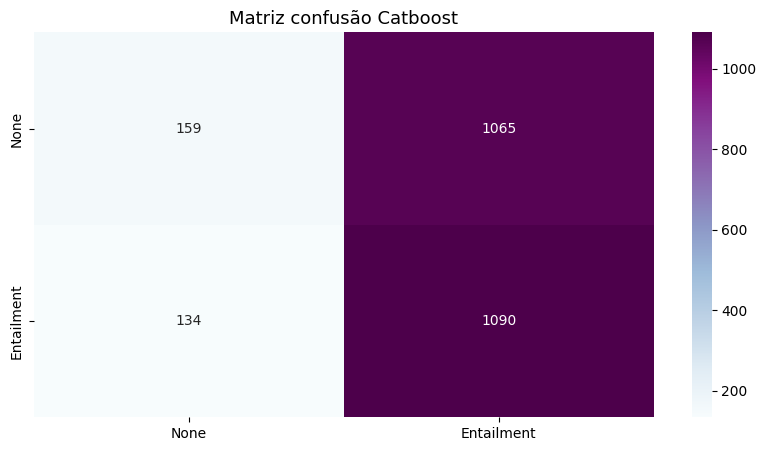

In [34]:
#  matriz de confusao 
cm = confusion_matrix(y_test, y_pred)
# Configura a opção de impressão para exibir todos os dígitos decimais
np.set_printoptions(precision=3, suppress=True)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print("\n Confusion Matrix:")
classes = ["None", "Entailment"]
plt.figure(figsize=(10,5))
plt.title('Matriz confusão Catboost', fontsize=13)
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d', xticklabels=classes, yticklabels=classes)


In [35]:
# inferencia
inferencia = pd.DataFrame(columns=["t", "h"])

# exemplo de entailment 
inferencia.loc[0] = ["Um macaco está andando de bike", "Um macaco está andando de bicicleta"]
# exemplo de none 
inferencia.loc[1] = ["O avião sul-africano está voando no céu azul", "O avião sul-africano não está voando em um céu azul"]

In [36]:
inferencia['embedding_t'] = inferencia['t'].apply(embeddings_func)
inferencia['embedding_h'] = inferencia['h'].apply(embeddings_func)

In [37]:
inferencia.head()

,t,h,embedding_t,embedding_h
0,Um macaco está andando de bike,Um macaco está andando de bicicleta,-0.02,-0.02
1,O avião sul-africano está voando no céu azul,O avião sul-africano não está voando em um céu...,-0.03,-0.03


In [38]:
# inferencia modelo 
y_inferencia = cat_model.predict(inferencia)
y_inferencia = np.round(y_inferencia)
print(y_inferencia)

[0 0]


<br>
<hr>
<br>
<br>